In [2]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from scipy.special import sinc
from nozzle import Spectral, Params, Nozzle

def quad(func:callable, xq: np.array, wq: np.array):
    """ 
    Gauss quadrature
    xq: array of quadrature points
    wq: array of quadrature weights
    """
    # s = 0
    # for xq_j, wq_j in zip(xq,wq):
    #     s += wq_j*func(xq_j)
    # return s
    return np.dot(wq, func(xq))

# sine DVR
Let $\psi_n(z) = \sqrt{\frac{2}{L}}\sin(\frac{n\pi}{L}(z-x_0)), n=1,\cdots,N$ be the orthorgonal functions on $[x_0,L]$. Then the "coordinate basis" functions is given by

$$ u_j(z) = w_j\sum_{n=1}^N \psi_n(z)\psi_n^*(z_j) $$

where $w_j$ is the j-th weight for the selected quadrature rule and $u_j$ satisfy the Kronecker delta property
$$ u_j(x_k) = \delta_{jk} $$

Now the solution becomes
$$ \xi(z) = \sum_{n=1}^{N} a_n u_n(z) $$

Text(0.5, 1.0, '$ \\int_0^\\pi u_i(x)u_j(x) $')

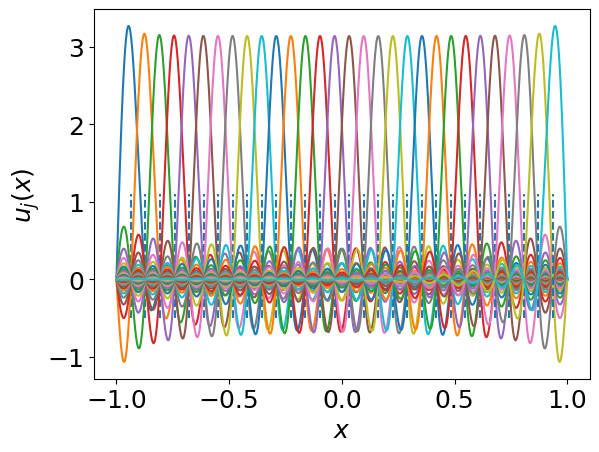

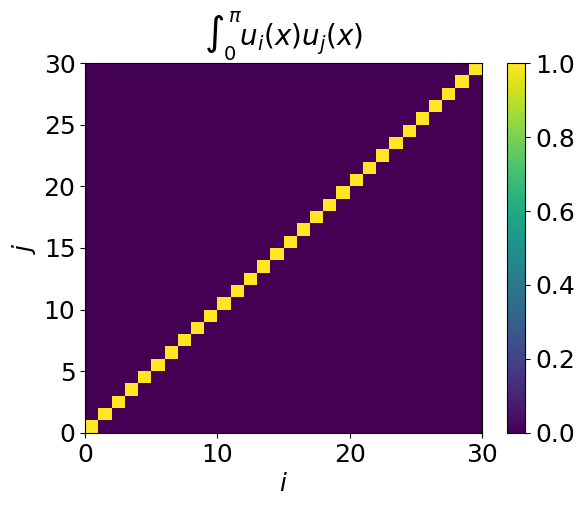

In [8]:
N = 30
L = 2
x0 = -1

xq = np.arange(1,N+1)*L/(N+1) + x0  # quadrature points
wq = np.pi/(N+1)*np.ones_like(xq) # quadrature weights
psi = lambda x,n: np.sqrt(2/L)*np.sin(n*np.pi/L*(x-x0))
psi_p = lambda x,n: np.sqrt(2/L)*n*np.pi/L*np.cos(n*np.pi/L*(x-x0)) 
psi_pp = lambda x,n: -np.sqrt(2/L)*(n*np.pi/L)**2*np.sin(n*np.pi/L*(x-x0)) 

def unnomalized_u(x,j):
    s = 0
    for n in range(N+1):
        s += psi(x,n)*psi(xq[j],n)
    return wq[j]*s

c = quad(lambda x: unnomalized_u(x,0)*unnomalized_u(x,0), xq,wq)
def u(x,j):
    return unnomalized_u(x,j)/np.sqrt(c)

def u_p(x,j):
    s = 0
    for n in range(N+1):
        s += psi_p(x,n)*psi(xq[j],n)/np.sqrt(c)
    return wq[j]*s

def u_pp(x,j):
    s = 0
    for n in range(N+1):
        s += psi_pp(x,n)*psi(xq[j],n)/np.sqrt(c)
    return wq[j]*s

x = np.linspace(x0,x0+L,1000)
plt.figure()
for j in range(N):
    plt.plot(x, u(x,j))
    plt.vlines(xq[j], -0.5,1.1,linestyles='--')
plt.ylabel("$u_j(x)$")
plt.xlabel("$x$")

plt.figure()
integrals = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        integrals[i,j] = quad(lambda x: u(x,i)*u(x,j), xq, wq)
plt.pcolormesh(integrals)
plt.colorbar()
plt.xlabel("$i$")
plt.ylabel("$j$")
plt.title("$ \int_0^\pi u_i(x)u_j(x) $")

<AxesSubplot:xlabel='$z$', ylabel='$\\tilde{v}$'>

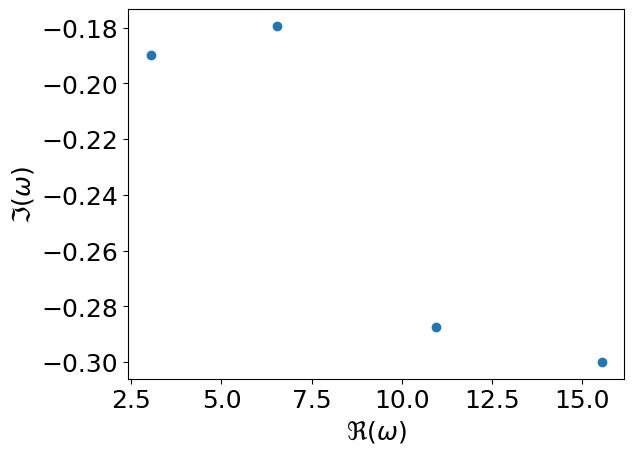

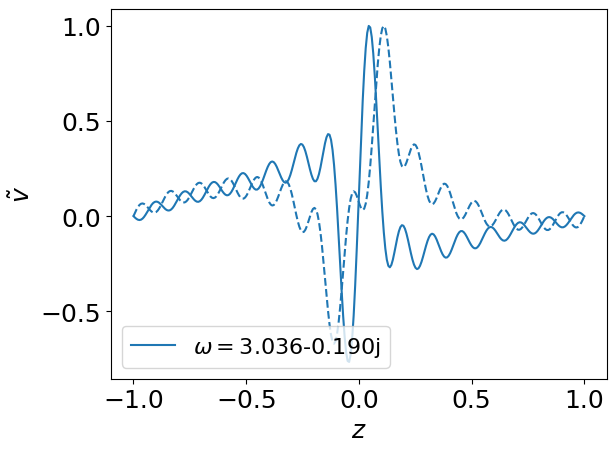

In [11]:
M = xq.size*10
Mm = 1.0
constant_v = False
accelerating = True
params = Params(Mm=Mm, constant_v=constant_v, accelerating=accelerating)
spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2
nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = lambda x: nozzle.velocity_profile(x)

xq_inds = [np.argmin(np.abs(x - spectral.x)) for x in xq]
_v0_p = D1@nozzle.v0
_v0_pp = D2@nozzle.v0
v0_p = lambda xq: _v0_p[xq_inds]
v0_pp = lambda xq: _v0_pp[xq_inds]

O = np.zeros((N,N), dtype=complex)
I = np.eye(N,dtype=complex)
A21 = np.zeros((N,N), dtype=complex)
A22 = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        A22[i,j] = -2j*quad(
            lambda x: u(x,i)*v0(x)*u_p(x,j) + u(x,i)*v0_p(x)*u(x,j),
            xq,wq)
        A21[i,j] = -quad(
            lambda x:
            u(x,i)*(1-v0(x)**2)*u_pp(x,j) -
            u(x,i)*(3*v0(x)+1/v0(x))*v0_p(x)*u_p(x,j) - 
            u(x,i)*(1-1/v0(x)**2)*v0_p(x)**2*u(x,j) -
            u(x,i)*(v0(x)+1/v0(x))*v0_pp(x)*u(x,j),
            xq,wq)
A = np.block([[O,I],[A21,A22]])

C, nozzle.omega = nozzle.solve(A)
nozzle.V = np.zeros((x.size, nozzle.omega.size), dtype=complex)
for i in range(nozzle.omega.size):
    for n in range(N):
        nozzle.V[:,i] += C[n,i]*u(x,n)
nozzle.sort_solutions(real_range=[0.1,20], imag_range=[-1,1])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions(num_funcs=1)
# nozzle.save_data("DVR_Sine", N=N)

# sinc DVR
Using the normalized $sinc$ function from scipy. 
$$sinc = \frac{\sin(\pi x)}{\pi x}$$

In [2]:
dx = 0.05
x_range = [-1,1]
xq = np.arange(x_range[0],x_range[1]+dx,dx)  # quadrature points
wq = dx*np.ones_like(xq) # quadrature weights

N = xq.size-2
u = lambda x,n: sinc((x-xq[n+1])/dx)/np.sqrt(dx)
u_p = lambda x,n: np.piecewise(
    x, 
    [~np.isclose((x-xq[n+1])/dx, 0)], 
    [lambda x: (np.pi*(x-xq[n+1])/dx*np.cos(np.pi*(x-xq[n+1])/dx)-np.sin(np.pi*(x-xq[n+1])/dx))/(np.pi*(x-xq[n+1])**2/dx)/np.sqrt(dx), 0]
)
u_pp = lambda x,n:np.piecewise(
    x, 
    [~np.isclose((x-xq[n+1])/dx, 0)], 
    [lambda x: -(np.pi/dx)**2*u(x,n) - 2*u_p(x,n)/(x-xq[n+1]), 0]
)

# x = np.linspace(*x_range,1000)

# plt.figure()
# for n in range(N):
#     plt.plot(x,u(x,n),label=f"$u_{n}$")
# #plt.legend()

# plt.figure()
# integrals = np.zeros((N,N))
# for i in range(N):
#     for j in range(N):
#         integrals[i,j] = quad(lambda x: u(x,i)*u(x,j), xq, wq)
# plt.pcolormesh(integrals)
# plt.colorbar()
# plt.xlabel("$i$")
# plt.ylabel("$j$")
# plt.title("$ \int_{%d}^{%d} u_i(x)u_j(x) $"%tuple(x_range))

<AxesSubplot:xlabel='$z$', ylabel='$\\tilde{v}$'>

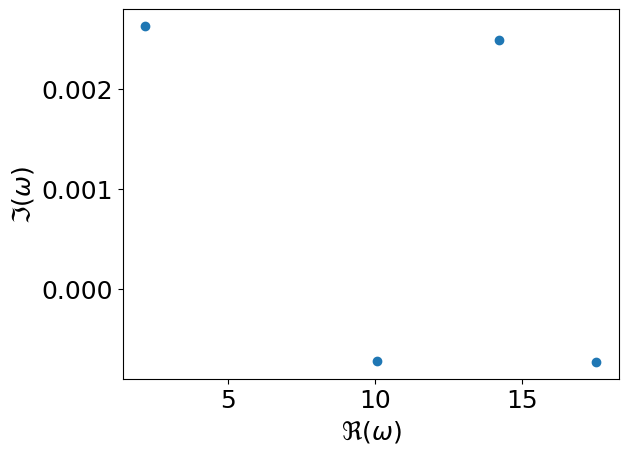

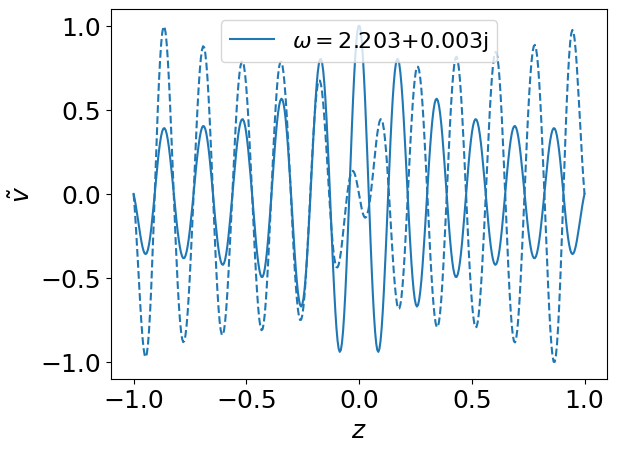

In [11]:
M = xq.size*10 # number of points
Mm = 0.5
constant_v = False
accelerating = False
params = Params(Mm=Mm, constant_v=constant_v, accelerating=accelerating)
spectral = Spectral(M, "symmetric", "FD")
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2
nozzle = Nozzle(params, x, lambda x,n: u(x,n))
v0 = lambda x: nozzle.velocity_profile(x)

def v0_p(xq):
    inds = [np.argmin(np.abs(x - spectral.x)) for x in xq]
    return (D1@nozzle.v0)[inds]

def v0_pp(xq):
    inds = [np.argmin(np.abs(x - spectral.x)) for x in xq]
    return (D2@nozzle.v0)[inds]

O = np.zeros((N,N), dtype=complex)
I = np.eye(N,dtype=complex)
A21 = np.zeros((N,N), dtype=complex)
A22 = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        A22[i,j] = -2j*quad(
            lambda x: u(x,i)*v0(x)*u_p(x,j) + u(x,i)*v0_p(x)*u(x,j),
            xq,wq)
        A21[i,j] = -quad(
            lambda x:
            u(x,i)*(1-v0(x)**2)*u_pp(x,j) -
            u(x,i)*(3*v0(x)+1/v0(x))*v0_p(x)*u_p(x,j) - 
            u(x,i)*(1-1/v0(x)**2)*v0_p(x)**2*u(x,j) -
            u(x,i)*(v0(x)+1/v0(x))*v0_pp(x)*u(x,j),
            xq,wq)
A = np.block([[O,I],[A21,A22]])
C, nozzle.omega = nozzle.solve(A)
nozzle.V = np.zeros((x.size, nozzle.omega.size), dtype=complex)
for i in range(nozzle.omega.size):
    for n in range(N):
        nozzle.V[:,i] += C[n,i]*u(x,n)

nozzle.sort_solutions(real_range=[0,20], imag_range=[-1,1])
nozzle.plot_eigenvalues()
nozzle.plot_eigenfunctions(num_funcs=1)

# nozzle.save_data("DVR_Sinc", N=N)

## Reproduce Fig2,3 in Electromagnetic instability of an axially inhomogeneous plasma

In [2]:
dx = 0.25
x_range = [-10,10]
xq = np.arange(x_range[0],x_range[1]+dx,dx)  # quadrature points
wq = dx*np.ones_like(xq) # quadrature weights

N = xq.size-2
u = lambda x,n: sinc((x-xq[n+1])/dx)/np.sqrt(dx)

u_p = lambda x,n: np.piecewise(
    x, 
    [~np.isclose((x-xq[n+1])/dx, 0)], 
    [lambda x: (np.pi*(x-xq[n+1])/dx*np.cos(np.pi*(x-xq[n+1])/dx)-np.sin(np.pi*(x-xq[n+1])/dx))/(np.pi*(x-xq[n+1])**2/dx)/np.sqrt(dx), 0]
)

M = xq.size*10 # number of points
params = Params(0.5, constant_v=True)
spectral = Spectral(M, "symmetric", "FD")
nozzle = Nozzle(params, spectral.x, lambda x,n: u(x,n))
x = 10*spectral.x

Text(0, 0.5, '$\\xi(z)$')

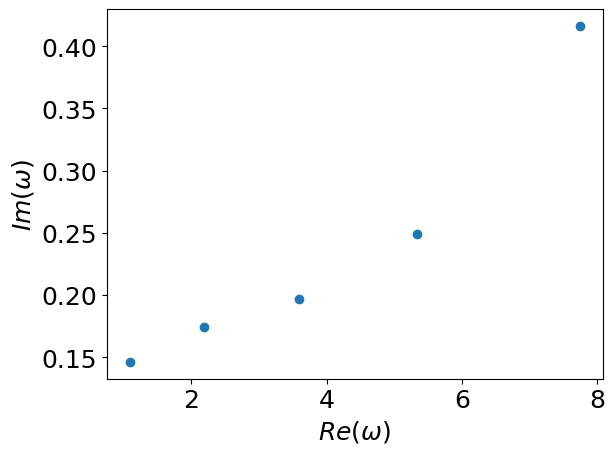

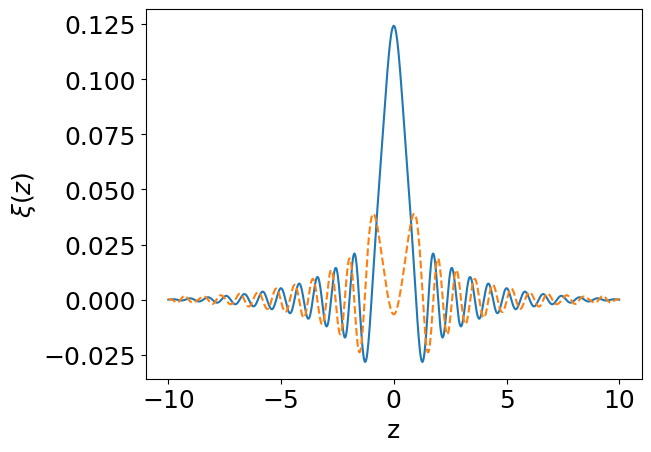

In [3]:
f = lambda x: 10*np.exp(-x**2)
# f = lambda x: 10/(1+x**2)

O = np.zeros((N,N), dtype=complex)
I = np.eye(N,dtype=complex)
H = np.zeros((N,N), dtype=complex)
F = np.zeros((N,N), dtype=complex)
for i in range(N):
    for j in range(N):
        H[i,j] = quad(
            lambda x: u_p(x,i)*u_p(x,j) - u(x,i)*f(x)**2*u(x,j),
            xq,wq)
        F[i,j] = quad(lambda x: u(x,i)*f(x)*u(x,j),xq,wq)
A = np.block([[O,I],[H,2*F]])

C, omega = nozzle.solve(A)

ind = np.argwhere(omega.imag > 0.01)
omega = omega[ind]
C = C[:,ind]

v = np.zeros(x.size, dtype=complex)
for i in range(N):
    v += C[i,0]*u(x, i)

plt.figure()
plt.plot(omega.real, omega.imag, "o")
plt.xlabel("$Re(\\omega)$")
plt.ylabel("$Im(\\omega)$")

plt.figure()
plt.plot(x, v.real, label="$\Re(\\xi)$")
plt.plot(x, v.imag, "--", label="$\Im(\\xi)$")
plt.xlabel("z")
plt.ylabel("$\\xi(z)$")